In [1]:
#######################Tensorflow 코드 시작부분
import librosa
import pyaudio #마이크를 사용하기 위한 라이브러리
import wave
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Dropout, Activation
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils.vis_utils import plot_model
from keras import regularizers
from keras.layers import BatchNormalization
import os
DATA_PATH = "./data/"
X_train = []#train_data 저장할 공간
X_test = []
Y_train = []
Y_test = []

tf_classes = 0
def load_wave_generator(path): 
       
    batch_waves = []
    labels = []
    X_data = []
    Y_label = []    
    global X_train, X_test, Y_train, Y_test, tf_classes
    
    folders = os.listdir(path)

    for folder in folders:
        if not os.path.isdir(path):continue #폴더가 아니면 continue                   
        files = os.listdir(path+"/"+folder)        
        print("Foldername :",folder,"-",len(files),"파일")
        #폴더 이름과 그 폴더에 속하는 파일 갯수 출력
        for wav in files:
            if not wav.endswith(".wav"):continue
            else:               
                #print("Filename :",wav)#.wav 파일이 아니면 continue
                y, sr = librosa.load(path+"/"+folder+"/"+wav)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=int(sr*0.01),n_fft=int(sr*0.02)).T
              
                X_data.extend(mfcc)
               # print(len(mfcc))
                
                label = [0 for i in range(len(folders))]
                label[tf_classes] = 1
                
                for i in range(len(mfcc)):
                    Y_label.append(label)
                #print(Y_label)
        tf_classes = tf_classes+1
    #end loop
    print("X_data :",np.shape(X_data))
    print("Y_label :",np.shape(Y_label))
 
    X_train, X_test, Y_train, Y_test = train_test_split(np.array(X_data), np.array(Y_label))
#train 75% test 25%

 
    xy = (X_train, X_test, Y_train, Y_test)
    np.save("./data.npy",xy)

load_wave_generator(DATA_PATH)


print(tf_classes,"개의 클래스!!")
print("X_train :",np.shape(X_train))
print("Y_train :",np.shape(Y_train))
print("X_test :",np.shape(X_test))
print("Y_test :",np.shape(Y_test))




Using TensorFlow backend.


Foldername : 0 - 21 파일
Foldername : 1 - 20 파일
Foldername : 2 - 19 파일
Foldername : 3 - 20 파일
Foldername : 4 - 24 파일
Foldername : 5 - 20 파일
Foldername : 6 - 19 파일
Foldername : 7 - 14 파일
Foldername : 8 - 23 파일
Foldername : 9 - 19 파일
Foldername : data_10 - 19 파일
X_data : (109843, 20)
Y_label : (109843, 11)
11 개의 클래스!!
X_train : (82382, 20)
Y_train : (82382, 11)
X_test : (27461, 20)
Y_test : (27461, 11)


In [2]:
#total = trian + test set
X_total = np.vstack([X_train, X_test])
Y_total = np.vstack([Y_train, Y_test])
print("X_total : ", np.shape(X_total))
print("Y_total : ", np.shape(Y_total))

X_total :  (109843, 20)
Y_total :  (109843, 11)


In [11]:
import datetime
##################  화자인식 NN 버전 ##################
X_train, X_test, Y_train, Y_test = np.load("./data.npy")
X_train = X_train.astype("float")
X_test = X_test.astype("float")


#keras
seed = 0 
np.random.seed(0)
tf.compat.v1.set_random_seed(0)
epochs, batch_size = 3000, 200 # batch -> 작을수록 좀 더 세밀한 조정 but 시간 많이걸림 
#512,256,256 Act0.1 Dropout0.2
start_time = datetime.datetime.now()
model = Sequential()
model.add(Dense(512, input_dim = 20))#1st hidden layer
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))
model.add(Dense(256))#2nd hidden layer  
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))
model.add(Dense(256))#3rd hidden layer 
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))
model.add(Dense(tf_classes, activation = 'softmax'))#최종레이어
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])



modelpath="./train_surv_time-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(X_train, Y_train, validation_split=0.3, epochs=epochs, 
                    batch_size=batch_size, shuffle=True, callbacks=[early_stopping_callback,checkpointer])

end_time = datetime.datetime.now()
print("\nelasped time = ",end_time- start_time)
print('Learning Finished!')

Train on 57667 samples, validate on 24715 samples
Epoch 1/3000
57667/57667 [==============================] - 9s 156us/step - loss: 2.0771 - accuracy: 0.4876 - val_loss: 0.8453 - val_accuracy: 0.7277

Epoch 00001: val_loss improved from inf to 0.84531, saving model to ./train_surv_time-0.8453.hdf5
Epoch 2/3000
57667/57667 [==============================] - 8s 145us/step - loss: 0.8139 - accuracy: 0.7250 - val_loss: 0.5719 - val_accuracy: 0.8014

Epoch 00002: val_loss improved from 0.84531 to 0.57194, saving model to ./train_surv_time-0.5719.hdf5
Epoch 3/3000
57667/57667 [==============================] - 8s 147us/step - loss: 0.6151 - accuracy: 0.7882 - val_loss: 0.4762 - val_accuracy: 0.8387

Epoch 00003: val_loss improved from 0.57194 to 0.47620, saving model to ./train_surv_time-0.4762.hdf5
Epoch 4/3000
57667/57667 [==============================] - 9s 148us/step - loss: 0.5462 - accuracy: 0.8115 - val_loss: 0.4273 - val_accuracy: 0.8611

Epoch 00004: val_loss improved from 0.47620 

57667/57667 [==============================] - 8s 139us/step - loss: 0.3423 - accuracy: 0.8831 - val_loss: 0.3180 - val_accuracy: 0.8922

Epoch 00037: val_loss did not improve from 0.30162
Epoch 38/3000
57667/57667 [==============================] - 8s 139us/step - loss: 0.3372 - accuracy: 0.8854 - val_loss: 0.3209 - val_accuracy: 0.8870

Epoch 00038: val_loss did not improve from 0.30162
Epoch 39/3000
57667/57667 [==============================] - 8s 140us/step - loss: 0.3397 - accuracy: 0.8832 - val_loss: 0.2953 - val_accuracy: 0.8985

Epoch 00039: val_loss improved from 0.30162 to 0.29529, saving model to ./train_surv_time-0.2953.hdf5
Epoch 40/3000
57667/57667 [==============================] - 9s 148us/step - loss: 0.3357 - accuracy: 0.8868 - val_loss: 0.3043 - val_accuracy: 0.8976

Epoch 00040: val_loss did not improve from 0.29529
Epoch 41/3000
57667/57667 [==============================] - 8s 141us/step - loss: 0.3379 - accuracy: 0.8841 - val_loss: 0.3031 - val_accuracy: 0.9007


57667/57667 [==============================] - 8s 141us/step - loss: 0.3007 - accuracy: 0.8981 - val_loss: 0.2771 - val_accuracy: 0.9063

Epoch 00076: val_loss did not improve from 0.26564
Epoch 77/3000
57667/57667 [==============================] - 8s 140us/step - loss: 0.2977 - accuracy: 0.8983 - val_loss: 0.2895 - val_accuracy: 0.9072

Epoch 00077: val_loss did not improve from 0.26564
Epoch 78/3000
57667/57667 [==============================] - 8s 140us/step - loss: 0.3043 - accuracy: 0.8975 - val_loss: 0.2665 - val_accuracy: 0.9056

Epoch 00078: val_loss did not improve from 0.26564
Epoch 79/3000
57667/57667 [==============================] - 8s 141us/step - loss: 0.3035 - accuracy: 0.8966 - val_loss: 0.2897 - val_accuracy: 0.9139

Epoch 00079: val_loss did not improve from 0.26564
Epoch 80/3000
57667/57667 [==============================] - 8s 138us/step - loss: 0.2977 - accuracy: 0.9001 - val_loss: 0.2622 - val_accuracy: 0.9116

Epoch 00080: val_loss improved from 0.26564 to 0.2

57667/57667 [==============================] - 9s 159us/step - loss: 0.2772 - accuracy: 0.9075 - val_loss: 0.2705 - val_accuracy: 0.9162

Epoch 00115: val_loss did not improve from 0.24209
Epoch 116/3000
57667/57667 [==============================] - 8s 141us/step - loss: 0.2725 - accuracy: 0.9101 - val_loss: 0.2752 - val_accuracy: 0.9198

Epoch 00116: val_loss did not improve from 0.24209
Epoch 117/3000
57667/57667 [==============================] - 8s 143us/step - loss: 0.2694 - accuracy: 0.9109 - val_loss: 0.3276 - val_accuracy: 0.8975

Epoch 00117: val_loss did not improve from 0.24209
Epoch 118/3000
57667/57667 [==============================] - 8s 143us/step - loss: 0.2802 - accuracy: 0.9077 - val_loss: 0.2407 - val_accuracy: 0.9264

Epoch 00118: val_loss improved from 0.24209 to 0.24071, saving model to ./train_surv_time-0.2407.hdf5
Epoch 119/3000
57667/57667 [==============================] - 8s 145us/step - loss: 0.2740 - accuracy: 0.9088 - val_loss: 0.2319 - val_accuracy: 0.9


Epoch 00153: val_loss did not improve from 0.21580
Epoch 154/3000
57667/57667 [==============================] - 8s 141us/step - loss: 0.2712 - accuracy: 0.9124 - val_loss: 0.2534 - val_accuracy: 0.9162

Epoch 00154: val_loss did not improve from 0.21580
Epoch 155/3000
57667/57667 [==============================] - 8s 142us/step - loss: 0.2503 - accuracy: 0.9185 - val_loss: 0.2262 - val_accuracy: 0.9330

Epoch 00155: val_loss did not improve from 0.21580
Epoch 156/3000
57667/57667 [==============================] - 8s 141us/step - loss: 0.2461 - accuracy: 0.9194 - val_loss: 0.2216 - val_accuracy: 0.9313

Epoch 00156: val_loss did not improve from 0.21580
Epoch 157/3000
57667/57667 [==============================] - 8s 141us/step - loss: 0.2467 - accuracy: 0.9188 - val_loss: 0.2466 - val_accuracy: 0.9295

Epoch 00157: val_loss did not improve from 0.21580
Epoch 158/3000
57667/57667 [==============================] - 8s 140us/step - loss: 0.2485 - accuracy: 0.9185 - val_loss: 0.2176 - v

57667/57667 [==============================] - 8s 140us/step - loss: 0.2380 - accuracy: 0.9213 - val_loss: 0.2105 - val_accuracy: 0.9294

Epoch 00193: val_loss did not improve from 0.19519
Epoch 194/3000
57667/57667 [==============================] - 8s 136us/step - loss: 0.2403 - accuracy: 0.9210 - val_loss: 0.2802 - val_accuracy: 0.9167

Epoch 00194: val_loss did not improve from 0.19519
Epoch 195/3000
57667/57667 [==============================] - 8s 137us/step - loss: 0.2366 - accuracy: 0.9235 - val_loss: 0.2151 - val_accuracy: 0.9360

Epoch 00195: val_loss did not improve from 0.19519
Epoch 196/3000
57667/57667 [==============================] - 8s 136us/step - loss: 0.2497 - accuracy: 0.9204 - val_loss: 0.2502 - val_accuracy: 0.9277

Epoch 00196: val_loss did not improve from 0.19519
Epoch 197/3000
57667/57667 [==============================] - 10s 176us/step - loss: 0.2446 - accuracy: 0.9213 - val_loss: 0.2315 - val_accuracy: 0.9340

Epoch 00197: val_loss did not improve from 0.

57667/57667 [==============================] - 8s 137us/step - loss: 0.2353 - accuracy: 0.9240 - val_loss: 0.2427 - val_accuracy: 0.9275

Epoch 00233: val_loss did not improve from 0.19519
Epoch 234/3000
57667/57667 [==============================] - 8s 138us/step - loss: 0.2411 - accuracy: 0.9232 - val_loss: 0.2252 - val_accuracy: 0.9381

Epoch 00234: val_loss did not improve from 0.19519
Epoch 235/3000
57667/57667 [==============================] - 8s 138us/step - loss: 0.2331 - accuracy: 0.9249 - val_loss: 0.2311 - val_accuracy: 0.9330

Epoch 00235: val_loss did not improve from 0.19519
Epoch 236/3000
57667/57667 [==============================] - 8s 143us/step - loss: 0.2352 - accuracy: 0.9251 - val_loss: 0.2148 - val_accuracy: 0.9374

Epoch 00236: val_loss did not improve from 0.19519

elasped time =  0:33:47.929795
Learning Finished!


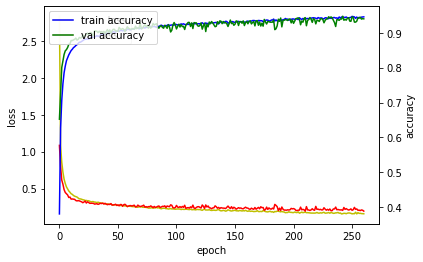

In [9]:
# test셋을 합쳐서 모델 초기화 후 learning -> epoch은 위에 참고해서 돌리기 , val_loss 기준 loss가 최소가 되었을때

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [7]:
#train + test 학습 반복


#keras
seed = 0 
np.random.seed(0)
tf.compat.v1.set_random_seed(0)
epochs, batch_size = 294, 150 # batch -> 작을수록 좀 더 세밀한 조정 but 시간 많이걸림 

start_time = datetime.datetime.now()

modelpath="./test_surv_time.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
train_again = model.fit(X_total, Y_total, validation_split=0.0, epochs=epochs, 
                    batch_size=batch_size, shuffle=True, callbacks = [checkpointer])

end_time = datetime.datetime.now()
print("\nelasped time = ",end_time- start_time)
print('Learning Finished!')



Epoch 1/294
109843/109843 [==============================] - 13s 116us/step - loss: 0.2365 - accuracy: 0.9221
Epoch 2/294
  2400/109843 [..............................] - ETA: 8s - loss: 0.2566 - accuracy: 0.9204

C:\user\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


109843/109843 [==============================] - 9s 83us/step - loss: 0.2381 - accuracy: 0.9219
Epoch 3/294
109843/109843 [==============================] - 9s 85us/step - loss: 0.2302 - accuracy: 0.9249
Epoch 4/294
109843/109843 [==============================] - 10s 87us/step - loss: 0.2312 - accuracy: 0.9237
Epoch 5/294
109843/109843 [==============================] - 9s 81us/step - loss: 0.2269 - accuracy: 0.9240
Epoch 6/294
109843/109843 [==============================] - 9s 81us/step - loss: 0.2209 - accuracy: 0.9265
Epoch 7/294
109843/109843 [==============================] - 9s 81us/step - loss: 0.2232 - accuracy: 0.9256
Epoch 8/294
109843/109843 [==============================] - 10s 87us/step - loss: 0.2255 - accuracy: 0.9260
Epoch 9/294
109843/109843 [==============================] - 9s 85us/step - loss: 0.2231 - accuracy: 0.9258
Epoch 10/294
109843/109843 [==============================] - 9s 83us/step - loss: 0.2208 - accuracy: 0.9265
Epoch 11/294
109843/109843 [=========

109843/109843 [==============================] - 10s 87us/step - loss: 0.1975 - accuracy: 0.9352
Epoch 152/294
109843/109843 [==============================] - 12s 105us/step - loss: 0.1920 - accuracy: 0.9359
Epoch 153/294
109843/109843 [==============================] - 13s 118us/step - loss: 0.2071 - accuracy: 0.9344
Epoch 154/294
109843/109843 [==============================] - 17s 155us/step - loss: 0.1936 - accuracy: 0.9368
Epoch 155/294
109843/109843 [==============================] - 11s 104us/step - loss: 0.2002 - accuracy: 0.9350
Epoch 156/294
109843/109843 [==============================] - 9s 81us/step - loss: 0.1999 - accuracy: 0.9347
Epoch 157/294
109843/109843 [==============================] - 9s 81us/step - loss: 0.2058 - accuracy: 0.9343
Epoch 158/294
109843/109843 [==============================] - 9s 81us/step - loss: 0.1951 - accuracy: 0.9364
Epoch 159/294
109843/109843 [==============================] - 9s 80us/step - loss: 0.1990 - accuracy: 0.9344
Epoch 160/294
1